In [1]:
# modelling potential

# df_activity: 
# medium but dataset too small
# logreg knn dtc rfc models: overfitting

# df_weight: 
# low

# df_sec: 
# aggregate to 1/5/15 min interval

# df_min: 
# intensity?

# df_hr: 
# lifestyle trends

### Contents

- [EDA](#EDA)

### Header

In [2]:
# user configuration

In [3]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score,r2_score,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.externals.six import StringIO 

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Import Data

In [4]:
# file paths

input_path = '../data/1_input/'
clean_path = '../data/2_clean/'
preprocess_path = '../data/3_preprocess/'
output_path = '../data/4_output/'

folder = 'fitbit/'

In [5]:
# import clean data

df_activity = pd.read_csv(clean_path + folder + 'activity.csv')
df_weight = pd.read_csv(clean_path + folder + 'weight.csv')

df_sec = pd.read_csv(clean_path + folder + 'seconds.csv')
df_min = pd.read_csv(clean_path + folder + 'minutes.csv')
df_hr = pd.read_csv(clean_path + folder + 'hours.csv')

### Functions

### Preprocess df_activity

In [6]:
# convert mins_act_xxx to mins_pct_xxx

# toggle
if False:    
    
    df_activity['mins_total'] = df_activity['mins_act_high'] + df_activity['mins_act_med'] + df_activity['mins_act_low'] + df_activity['mins_act_sede']

    df_activity['mins_pct_high'] = df_activity['mins_act_high'] / df_activity['mins_total']
    df_activity['mins_pct_med'] = df_activity['mins_act_med'] / df_activity['mins_total']
    df_activity['mins_pct_low'] = df_activity['mins_act_low'] / df_activity['mins_total']
    df_activity['mins_pct_sede'] = df_activity['mins_act_sede'] / df_activity['mins_total']

    cols = ['mins_total','mins_act_high','mins_act_med', 'mins_act_low','mins_act_sede']
    df_activity.drop(columns=cols,inplace=True)

In [7]:
# filter rows

mask_steps = df_activity['steps'] >= 1000
df_activity_2 = df_activity[mask_steps]

In [8]:
# drop columns

cols = ['timestamp','year','month', 'day']
df_activity_2.drop(columns=cols,inplace=True)

In [9]:
# create dummies

df_activity_2 = pd.get_dummies(df_activity_2,columns=['dayweek'],drop_first=True)

In [10]:
# check df

print(df_activity_2.shape)
df_activity_2.head()

(370, 18)


,id,steps,calories,dist_total,dist_act_high,dist_act_med,dist_act_low,dist_act_sede,mins_act_high,mins_act_med,mins_act_low,mins_act_sede,dayweek_Monday,dayweek_Saturday,dayweek_Sunday,dayweek_Thursday,dayweek_Tuesday,dayweek_Wednesday
0,1,11004,1819,7.10,2.57,0.46,4.07,0.0,33,12,205,804,0,0,0,0,0,0
1,1,17609,2154,11.56,6.92,0.73,3.91,0.0,89,17,274,588,0,1,0,0,0,0
2,1,12736,1944,8.53,4.66,0.16,3.71,0.0,56,5,268,605,0,0,1,0,0,0
3,1,13231,1932,8.93,3.19,0.79,4.95,0.0,39,20,224,1080,1,0,0,0,0,0
4,1,12041,1886,7.86,2.16,1.09,4.61,0.0,28,28,243,763,0,0,0,0,1,0


### Preprocess df_hr

In [11]:
# drop columns

cols = ['timestamp','year','month', 'day','min','sec','intensity_avg']
df_hr.drop(columns=cols,inplace=True)

In [12]:
# create dummies

df_hr = pd.get_dummies(df_hr,columns=['dayweek'],drop_first=True)

In [13]:
# check df

print(df_hr.shape)
df_hr.head()

(24084, 11)


,id,hour,steps,calories,intensity_total,dayweek_Monday,dayweek_Saturday,dayweek_Sunday,dayweek_Thursday,dayweek_Tuesday,dayweek_Wednesday
0,1,0,0,48,0,0,1,0,0,0,0
1,1,1,0,48,0,0,1,0,0,0,0
2,1,2,0,48,0,0,1,0,0,0,0
3,1,3,0,48,0,0,1,0,0,0,0
4,1,4,0,48,0,0,1,0,0,0,0



### Create Features and Target

In [14]:
# toggle

#df_model = df_activity.copy()
df_model = df_hr.copy()

In [15]:
target = 'id'
features = [x for x in df_model.columns if x != target]

X = df_model[features].values
y = df_model[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,stratify=y,random_state=3050)

In [16]:
# check

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16858, 10)
(7226, 10)
(16858,)
(7226,)


In [17]:
# toggle
if False:

    # df_activity
    #scale_idx = 11
    #scale_idx = 8 
    scale_idx = 12
    
    # df_hr

    ss = StandardScaler()
    ss.fit(X_train[:,:scale_idx])

    X_train_scale = ss.transform(X_train[:,:scale_idx])
    X_test_scale = ss.transform(X_test[:,:scale_idx])

    X_train[:,:scale_idx] = X_train_scale
    X_test[:,:scale_idx] = X_test_scale
    
    print(X_train.shape)
    print(X_test.shape)
    print(X_train_scale.shape)
    print(X_test_scale.shape)

### Logistic Regression Model

In [18]:
# init model

logreg = LogisticRegression()

In [19]:
# perform cross validation

score = cross_val_score(logreg,X,y,cv=5)
mse = cross_val_score(logreg,X,y,cv=5,scoring='neg_mean_squared_error')
r2 = cross_val_score(logreg,X,y,cv=5,scoring='r2')

print('score:',score.mean(),score)
print('mse:',mse.mean(),mse)
print('r2:',r2.mean(),r2)

score: 0.22413353923959628 [0.21934548 0.21422646 0.22969886 0.24532613 0.21207076]
mse: -145.39016209069015 [-155.78873239 -146.05163832 -146.53229491 -125.55712505 -153.02101977]
r2: -0.3497192006737789 [-0.44676301 -0.3561668  -0.35961411 -0.1653915  -0.42066059]


In [20]:
# fit model

logreg.fit(X_train, y_train)

# score model
print("train r2:",logreg.score(X_train, y_train))
print("test r2:",logreg.score(X_test, y_test))

# validate model
y_pred = logreg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 0.23330169652390556
test r2: 0.2099363409908663
rmse: 12.288155048568006


In [21]:
# output model results to csv

# cols = ['y_test']
# df_result = pd.DataFrame(y_test,columns=cols)

# df_result['y_pred'] = y_pred
# df_result['result'] = False

# for idx,row in df_result.iterrows():  

#     if row['y_test'] == row['y_pred']:
#         df_result.at[idx,'result'] = True

# df_result
# df_result.to_csv('df_result.csv')

### KNN Model

In [22]:
# init model

knn = KNeighborsClassifier(n_neighbors=2)

#n_neighbors=2
#n_neighbors=3
#n_neighbors=4
n_neighbors=5

In [23]:
# perform cross validation

score = cross_val_score(knn,X,y,cv=5)
mse = cross_val_score(knn,X,y,cv=5,scoring='neg_mean_squared_error')
r2 = cross_val_score(knn,X,y,cv=5,scoring='r2')

print('score:',score.mean(),score)
print('mse:',mse.mean(),mse)
print('r2:',r2.mean(),r2)

score: 0.47667301734374234 [0.48840099 0.5012443  0.48951194 0.47569589 0.42851197]
mse: -98.76448364208622 [ -93.69076222  -93.85607632  -97.88265836  -98.00145409 -110.39146722]
r2: 0.08313893128100455 [ 0.12992213  0.12849663  0.09178626  0.09037372 -0.02488408]


In [24]:
# fit model

knn.fit(X_train, y_train)

# score model
print("train r2:",knn.score(X_train, y_train))
print("test r2:",knn.score(X_test, y_test))

# validate model
y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 0.7085063471348915
test r2: 0.4732908939939109
rmse: 10.014216299491315


### DTC Model

In [25]:
# init model

dtc = DecisionTreeClassifier(max_depth=5,random_state=3050)

In [26]:
# perform cross validation

score = cross_val_score(dtc,X,y,cv=5)
print(score.mean(),score)

0.253649210978717 [0.27568351 0.28224803 0.27663551 0.24137931 0.19229969]


In [27]:
# fit model
dtc = dtc.fit(X_train,y_train)

# score model
print("train r2:",dtc.score(X_train, y_train))
print("test r2:",dtc.score(X_test, y_test))

# validate model
y_pred = dtc.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 0.256614070470993
test r2: 0.2586493218931636
rmse: 15.455443847836547


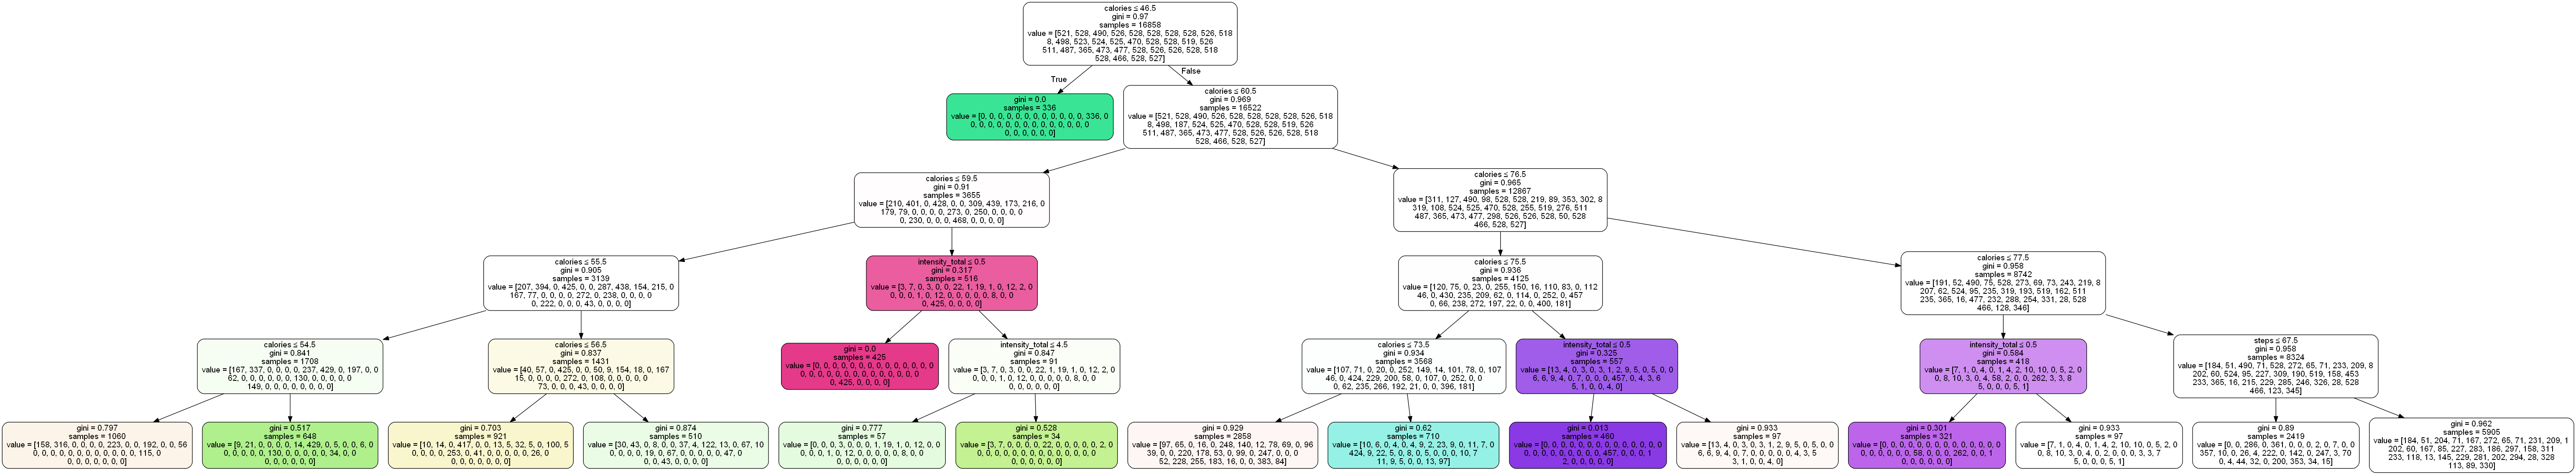

In [28]:
# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtr1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtc, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names=df_model[features].columns
               )  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### RFC Model

In [29]:
# init model

rfc = RandomForestClassifier(n_estimators=10,max_depth=5,n_jobs=2, random_state=3050)

In [30]:
# perform cross validation

score = cross_val_score(rfc,X,y,cv=5)
print(score.mean(),score)

0.20683239840499654 [0.1963546  0.23745334 0.2741433  0.17303698 0.15317378]


In [31]:
# fit model
rfc = rfc.fit(X_train,y_train)

# score model
print("train r2:",rfc.score(X_train, y_train))
print("test r2:",rfc.score(X_test, y_test))

# validate model
y_pred = rfc.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 0.2515126349507652
test r2: 0.23263216163852754
rmse: 12.400185484715768
